In [1]:
import os, sys, shutil
sys.path.insert(0,"/home/hschia/data/love")
sys.path.insert(-1, "/home/hschia/PE/gw_detection_ias")

# Standard Python libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import interpolate
from importlib import reload
import multiprocess, json
import time
import pickle
import glob
from pprint import pprint

# GW pipeline
import params_love as params
import utils_love as utils
import triggers_single_detector

# %matplotlib widget
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 5)

In [2]:
DIR = '/home/hschia/data/love'
PSD_DIR = 'psd_comparison'

In [3]:
# Select name of observing run
run = 'O3a'

asd_file = os.path.join(DIR, PSD_DIR, f'ref_asd_{run}_median.npy')

if run == 'O1':
    fnames = [f for f in glob.glob('/data/bzackay/GW/OutputDir/O1_Mon_Apr_8_13_36O2_BBH_2_multibank_bank_0/*.json')
            if ('H1' in f or 'L1' in f)]
elif run == 'O2':
    fnames = [f for f in glob.glob('/data/bzackay/GW/OutputDir/O2_Sat_Mar_9_22_16O2_BBH_1_multibank_bank_0/*.json')
            if ('H1' in f or 'L1' in f)]
elif run == 'O3a':
    fnames = [f for f in glob.glob('/data/bzackay/GW/O3Events/*/*.json')
              if ('H1' in f or 'L1' in f) and not 'GW190425' in f]
elif run == 'O3b':
    fnames = [f for f in glob.glob('/scratch/lustre/srolsen/GW/OutputDir/O3b_Tue_Mar_22_19_08O3a_BBH_2_multibank_bank_1/*.json')
            if ('H1' in f or 'L1' in f)]

In [4]:
# Create median PSD from n_files randomly drawn time series raw data files

n_files = min(100, len(fnames))
f_full = np.geomspace(10, 1e3, 1000)  # (asd below params.FMIN_PSD=15Hz is inf, cf. d_ops.data_to_asdfunc); 
percentile = 50

if not os.path.isfile(asd_file):
    
    # Use Welch's method to estimate PSD for each file
    asds = np.array([triggers_single_detector.TriggerList.from_json(fname).asdfunc(f_full)
                     for fname in np.random.choice(fnames, n_files, replace=False)])
    ref_asd = np.percentile(asds, percentile,  axis=0)

    # Occasionally need to convert nan to inf for good behaviour later
    ref_asd = np.nan_to_num(ref_asd, nan=np.inf)
    
    np.save(asd_file, np.vstack((f_full, ref_asd)))
else:
    print(f"File {asd_file} exists, didn't overwrite")

File /home/hschia/data/love/psd_comparison/ref_asd_O3a_median.npy exists, didn't overwrite


## Load test asds

In [5]:
asd_o1 = np.load('/home/hschia/data/love/psd_comparison/ref_asd_O1_median.npy')
asd_o2 = np.load('/home/hschia/data/love/psd_comparison/ref_asd_O2_median.npy')
asd_o3a = np.load('/home/hschia/data/love/psd_comparison/ref_asd_O3a_median.npy')
asd_o3b = np.load('/home/hschia/data/love/psd_comparison/ref_asd_O3b_test.npy')

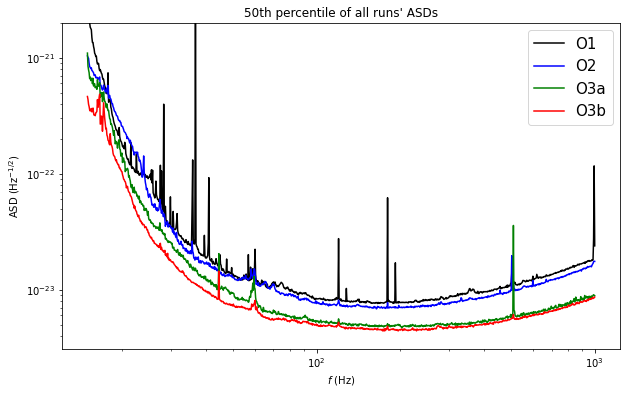

In [6]:
plt.figure(figsize=(10,6))

plt.loglog(f_full, asd_o1[1], 'k', lw=1.5, label='O1')
plt.loglog(f_full, asd_o2[1], 'b', lw=1.5, label='O2')
plt.loglog(f_full, asd_o3a[1], 'g', lw=1.5, label='O3a')
plt.loglog(f_full, asd_o3b[1], 'r', lw=1.5, label='O3b')
plt.title(f"{percentile}th percentile of all runs' ASDs")
plt.xlabel(r'$f$ (Hz)')
plt.ylabel(r'ASD (Hz$^{-1/2}$)')
plt.ylim(top=2e-21);
plt.legend(fontsize=15)